In [226]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Getting the data

In [227]:
# download the names.txt file from github

import requests

url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"

In [228]:
response = requests.get(url)

if response.status_code == 200:
    with open("names.txt", "w") as file:
        file.write(response.text)
    print("Le fichier a été téléchargé avec succès.")
else:
    print("Le téléchargement du fichier a échoué")

Le fichier a été téléchargé avec succès.


In [229]:
# response.text.splitlines() allows us to directly get the list but in the case I'm working offline, I download locally the file

In [230]:
#with open("names.txt", "r") as file:
#    raw_names = file.read()

raw_names = open('names.txt', 'r').read()

In [231]:
names = raw_names.splitlines()
print(len(names))
names[:5]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia']

# Building the vocabulary of characters and mapping it

In [232]:
characters = sorted(list(set(''.join(name for name in names))))
char_to_int = {char:i+1 for i, char in enumerate(characters)}
char_to_int["."] = 0 #special character to begin of put an end to a sequence
int_to_char = {i:char for char, i in char_to_int.items()}

# Building the dataset

In [233]:
context_size = 4 # number of precedents char to take into account

def build_dataset(words, context_size):
    X = []
    y = []

    for name in names:
        context = [0] * context_size

        for char in name + '.':
            idx = char_to_int[char]
            X.append(context)
            y.append(idx)

            #print(f"{''.join(int_to_char[i] for i in context)}")

            context = context[1:] + [idx]

    X, y = torch.tensor(X), torch.tensor(y)
    print(f"X.shape : {X.shape}, y.shape : {y.shape}")

    return X, y

In [234]:
X, y = build_dataset(names, context_size)

X.shape : torch.Size([228146, 4]), y.shape : torch.Size([228146])


In [235]:
import random
random.seed(42)
random

n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])

Xtr, Xval, Xtst = X.tensor_split((n1, n2), dim=0)
ytr, yval, ytst = y.tensor_split((n1, n2), dim=0)

In [236]:
print(f"Xtr.shape : {Xtr.shape}, Xval.shape : {Xval.shape}, Xtst.shape : {Xtst.shape}")

Xtr.shape : torch.Size([182516, 4]), Xval.shape : torch.Size([22815, 4]), Xtst.shape : torch.Size([22815, 4])


# Designing the MLP

In [304]:
g = torch.Generator().manual_seed(42) # for reproductibility

In [ ]:
C = torch.rand([27, 2], generator=g) # characters to vectors
W1 = torch.rand([4*2, 200], generator=g) # putting in the MLP 4 characters and each one of them has 2 dimensionnal vector associated
b1 = torch.rand(200, generator=g)
W2 = torch.rand([200, 27], generator=g)
b2 = torch.rand(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True # we need to give this information to torch

In [306]:
# number of parameters in total

sum(p.nelement() for p in parameters)

7281

# Train the model

In [307]:
loss_i, loss_val = [], []
iterations = 200000

In [ ]:
def training_and_valid(Xtrain, ytrain, Xvalid, yvalid, iterations, batch_size):

    for i in range(iterations):
        if i % 2000 == 0:
            print(i)
        # batch construction
        batch_idx = torch.randint(0, Xtr.shape[0], (batch_size,))

        # forward pass
        emb = C[Xtrain[batch_idx]]
        h = F.tanh(emb.view(-1, 8) @ W1 + b1)
        logits = h @ W2 + b2

        loss = F.cross_entropy(logits, ytrain[batch_idx])

        # backward pass
        for p in parameters:
            p.grad = None # reset the gradient to avoid accumulation
        loss.backward()

        # update
        lr = 0.1 if i < 150000 else 0.01
        for p in parameters:
            p.data += - lr * p.grad
        
        loss_i.append(loss.item())

        # validation set
        #if i % 150: # saving time
        #    emb = C[Xvalid]
        #    h = F.tanh(emb.view(-1, 8) @ W1 + b1)
        #    logits = h @ W2 + b2
        #    loss_val.append(F.cross_entropy(logits, yvalid).item())
        #else:
        #    loss_val.append(loss_val[-1])

    return loss_i, loss_val

In [309]:
train_loss, val_loss = training_and_valid(Xtrain=Xtr, ytrain=ytr, Xvalid=Xval, yvalid=yval, iterations=iterations, batch_size=32)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000
70000
72000
74000
76000
78000
80000
82000
84000
86000
88000
90000
92000
94000
96000
98000
100000
102000
104000
106000
108000
110000
112000
114000
116000
118000
120000
122000
124000
126000
128000
130000
132000
134000
136000
138000
140000
142000
144000
146000
148000
150000
152000
154000
156000
158000
160000
162000
164000
166000
168000
170000
172000
174000
176000
178000
180000
182000
184000
186000
188000
190000
192000
194000
196000
198000


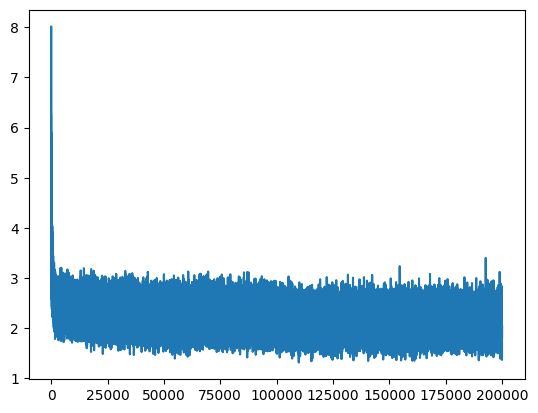

In [310]:
x = torch.arange(0, iterations)

plt.plot(x, train_loss)
#plt.plot(x, val_loss)

plt.show()

In [311]:
# val_loss

emb = C[Xval]
h = F.tanh(emb.view(-1, 8) @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, yval).item()
val_loss

2.3724355697631836

# Vizualising character embedding

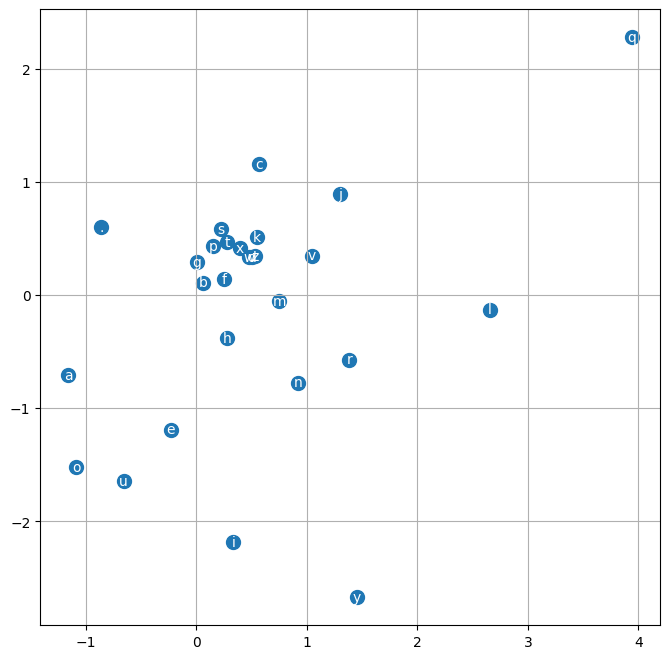

In [312]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:, 1].data, s=100)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), int_to_char[i], ha="center", va="center", color='white')

plt.grid(True)

plt.show()

# Trying to make more names !